In [1]:
# v1.2 수수료 기반 백테스팅 작업, AI 이용한 upper, lower 예측(분류모델 + gridcv로 최적 파라미터 설정), 코드 정리 
# v1.1 확대 축소가 아닌 Low, Upper에 닿을 경우 매수, 매도 결정, 5일 이동평균선 기준
# v1.0 볼린저 밴드 (확대, 축소)를 이용한 알고리즘 매수, 매도 결정

import pandas as pd
import numpy as np
import pyupbit
import datetime
import time
import os

# # min_key numbers
# access_key='WNlqEotmOTIxYKvgtrQupedaIgEnultRrTMeUxAa'
# secret_key='91I4c67FhA88yRLTCuYp7DNphTc0jOEVd0x302R1'

# jiwoo numbers
access_key='RxxAtjdh5TCBv4Wc9ycWKILVBsDhE3ZeiJVXadxF'
secret_key='xavsrBGokR5fqeivyA4ctxFrJgMfjbCCJmxRY5I5'

upbit=pyupbit.Upbit(access_key,secret_key) # upbit 함수 이용하기

# 초기 데이터 추천
def start_settings(tickers):
    # 6시간 데이터 확보
    time2=datetime.datetime.now().strftime('%Y-%m-%d %H:%M:00')
    data = pyupbit.get_ohlcv(tickers, interval="minute1", count=120, to=time2) # 120분 추출
    i=1
    while(i<3): # 데이터 수 확장하기  (6시간 데이터 추출)
            date = data.index[0]
            data2 = pyupbit.get_ohlcv(tickers, interval="minute1", count=120, to=date)
            data = pd.concat([data,data2], axis=0)  
            data = data.sort_index()
            i+=1
            time.sleep(1)
    return data

# Data 확보
def settings(tickers):
    # 48시간 데이터 확보
    time2=datetime.datetime.now().strftime('%Y-%m-%d %H:%M:00')
    data = pyupbit.get_ohlcv(tickers, interval="minute1", count=120, to=time2)  # 120분 추출
    i=1
    while(i<36): # 데이터 수 확장하기  (72시간 데이터 추출) # 3일치
            date = data.index[0]
            data2 = pyupbit.get_ohlcv(tickers, interval="minute1", count=120, to=date)
            data = pd.concat([data,data2], axis=0)  
            data = data.sort_index()
            i+=1
            time.sleep(1)
    return data

# 볼린저밴드 만들기(upper, middle, lower)
def BAND_data(df):
    
    #종가를 이용
    df['line_5']=df['close'].rolling(window=5).mean() # 5일 이동평균선
    df['line_10']=df['close'].rolling(window=10).mean() # 10일 이동평균선
    df['band_mid']=df['close'].rolling(window=20).mean() # 20일 이동평균선
    df['band_up']=df['band_mid']+(df['close'].rolling(window=20).std()*2)  # upper
    df['band_low']=df['band_mid']-(df['close'].rolling(window=20).std()*2)  # lower
    df=df.fillna(0) # 없는 데이터 채우기
    return df

#양봉, 음봉 캔들 생성
def minute_1(temp_df, i):
    blue_b_price=0
    blue_t_price=0
    blue=0
    red_b_price=0
    red_t_price=0
    red=0
    # 일봉 매수, 매도 점 위치 파악 (빨간색, 파란색인지 구별) -> 가격 변수 설정
    chai= (np.round(temp_df.loc[temp_df.index[i],'open'],0) - np.round(temp_df.loc[temp_df.index[i],'close'],0)).astype('float')
    if chai >= 0.0: # 음봉
        blue_b_price=np.round(temp_df.loc[temp_df.index[i],'close'],0)
        blue_t_price=np.round(temp_df.loc[temp_df.index[i],'open'],0)
        blue=1
    else: #양봉
        red_b_price=np.round(temp_df.loc[temp_df.index[i],'open'],0)
        red_t_price=np.round(temp_df.loc[temp_df.index[i],'close'],0)   
        red=1
        
    return blue_b_price, blue_t_price, blue, red_b_price, red_t_price, red

# 볼린저 밴드를 이용한 매수 매도 누적 수익률 test 함수
def band_trainig(temp_df):
    temp_df['B/S']=0  # buy=1, sell=-1
    sign=0  # 매수 or 매도 타이밍
    cnt=0 # 매수 개수
    
    for i in range(1,len(temp_df)):
        mid_price=temp_df.loc[temp_df.index[i],'band_mid']
        upper=temp_df.loc[temp_df.index[i],'band_up']
        lower=temp_df.loc[temp_df.index[i],'band_low']
        line_5=temp_df.loc[temp_df.index[i],'line_5']
        blue=0
        red=0
        
        # 일봉 매수, 매도 점 위치 파악 (빨간색, 파란색인지 구별) -> 가격 변수 설정
        blue_b_price, blue_t_price, blue, red_b_price, red_t_price, red = minute_1(temp_df, i)
            
        if blue==1 and upper<blue_t_price and mid_price<blue_t_price:   #블루봉 사인
            sign=-1 # 매도 타이밍 발생
        elif blue==1 and lower>blue_b_price and mid_price>blue_b_price: 
            sign=1 # 매수 타이밍 발생(1)
        elif red==1 and upper<red_t_price and mid_price<red_t_price:    #레드봉 사인
            sign=-1 # 매도 타이밍 발생(-1)
        elif red==1 and lower>red_b_price and mid_price>red_b_price:
            sign=1 # 매수 타이밍 발생
        
        if sign==-1: # 시그널 지속하며 꺾는점 발생 (진정한 매도 타이밍)
            if blue==1 and blue_t_price<line_5 and mid_price<blue_b_price and cnt>0: # 고점형성 기준 블루봉일시 매도
                temp_df.loc[temp_df.index[i],'B/S']=-1   # 매도한다. 
                cnt=0
                sign=0

            elif red==1 and red_t_price<line_5 and mid_price<red_b_price and cnt>0: # 고점형성 기준 레드봉일시 매도
                temp_df.loc[temp_df.index[i],'B/S']=-1   # 매도한다. 
                cnt=0
                sign=0
                
        elif sign==1: # 시그널 지속하며 꺾는점 발생 (진정한 매수 타이밍)
            if red==1 and mid_price>red_b_price and red_b_price>line_5: # 저점형성 기준 레드봉일시 매수 (레드봉일시만 매수!! (핵심))
                temp_df.loc[temp_df.index[i],'B/S']=1   # 매수한다. 
                cnt+=1
                sign=0
    return temp_df

#누적수익률 계산 함수
def test_rate(temp_df):
    price=0
    cnt=0 # 처음 개수
    sell_rate=[] # 기간별 수익률
    cnt_sum=[]
    total_rate=1
    fee=0.0005  # upbit 수수료 고려
    for i in range(1,len(temp_df)):
        # 일봉 매수, 매도 점 위치 파악 (빨간색, 파란색인지 구별) -> 가격 변수 설정
        blue_b_price, blue_t_price, blue, red_b_price, red_t_price, red = minute_1(temp_df, i)
        
        if temp_df.loc[temp_df.index[i],'B/S']==1 and red==1:   # 매수는 시가로 매수한다. (red일시만 매수)
            price=(price+(red_b_price*(1.0+fee))) # red일 시 아랫 부분
            cnt+=1
        elif temp_df.loc[temp_df.index[i],'B/S']==-1 and cnt>0  and (blue==1 or red==1): # 매도
            if blue==1:  # 블루일시 윗 부분
                sell_p=(blue_t_price*cnt*(1.0-fee))
            elif red==1: # 레드일시 윗 부분
                sell_p=(red_t_price*cnt*(1.0-fee))
            rate=np.round(((sell_p-price)/price),4)
            sell_rate.append(rate)
            cnt_sum.append(cnt)
            price=0
            cnt=0
    # 총 누적수익률
    try:
        for rate in sell_rate:
            total_rate*=(1+rate)
        total_rate-=1
        total_rate=np.round(total_rate*100,5)
        if len(cnt_sum)!=0:
            cnt_max=max(cnt_sum)
        else:
            cnt_max=0
    except:
        cnt_max='error'
        total_rate='error'
    return total_rate, cnt_max

def not_trade(tickers, time2): # 미체결된 주문 취소
    ret=upbit.get_order(tickers, state='wait')
    i=0
    while len(ret)!=0:
        ret=upbit.get_order(tickers)
        uuid=ret.pop(0)['uuid']
        ret2=upbit.cancel_order(uuid)
        print('{0} 미체결된 주문 {2} 중 {1}원이 취소되었습니다.'.format(time2,ret2['price'],tickers[4:]))
        i+=1

def buy_trade(tickers, time2, cnt, buy_cnt): #매수 함수
    try:
        ret=upbit.get_balances()
        check=0
        for name in ret:
            if name['currency']==tickers[4:]:  # 잔고에 있는 매수가 확인
                if float(name['avg_buy_price'])>price:
                    check=0
                else:
                    check=1
        price=pyupbit.get_current_price(tickers)
        if check==1:
            print('잔고에 있는 평균가 {0}원이 주문가격 {1}원보다 낮아 매수 주문이 취소되었습니다.'.format(name['avg_buy_price'],price))
        else: 
            ret = upbit.buy_market_order(tickers, price*buy_cnt) # 시장가 매수를 가격으로 한다.
            cnt+=1
            print('{1} 으로 {2}는 {0}원으로 현재 {4}{3}를 매수 주문 완료했습니다.'.format(price,time2,tickers,tickers[4:],buy_cnt)) 
        return cnt, price
    except:
        print(ret)
        return cnt, price

def sell_trade(tickers, time2, cnt, buy_cnt): #매도 함수   
    try:
        ret=upbit.get_balances()
        for name in ret:
            if name['currency']==tickers[4:]:  # 잔고에 있는 매수평균가 서칭
                avg_buy_price=float(name['avg_buy_price'])
                ret = upbit.sell_market_order(tickers, buy_cnt*cnt)
                price=pyupbit.get_current_price(tickers)
                while True:
                    if len(upbit.get_order(tickers, state='wait'))==0:
                        print('{1} 기준으로 {2}는 {0}원으로 주문({3}) 만큼 매도 완료했습니다.'.format(price,time2,tickers[4:],buy_cnt))
                        avg_price=np.round(((price-avg_buy_price)/avg_buy_price*100),2)
                        print('{0} 수익률은 {1}% 입니다.'.format(time2,avg_price))
                        cnt=0
                        break
        return cnt, price
    except:
        print(ret)
        return cnt, price

# 매수 or 매도 프로그램
def trade(tickers, df, buy_cnt, sign, cnt): # sign=매수 or 매도 타이밍 # band_trainig 에서 결정된 signal 값
    
    #최신데이터 band 형성
    df=BAND_data(df)
    line_5=df.loc[df.index[-1],'line_5']
    line_10=df.loc[df.index[-1],'line_5']
    upper=df.loc[df.index[-1],'band_up']
    lower=df.loc[df.index[-1],'band_low']
    df.loc[df.index[-1],'B/S']=0
    blue=0
    red=0
    
    # 일봉 매수, 매도 점 위치 파악 (빨간색, 파란색인지 구별) -> 가격 변수 설정
    blue_b_price, blue_t_price, blue, red_b_price, red_t_price, red = minute_1(df, -1)
    
    #변수 설정
    price=pyupbit.get_current_price(tickers)  #현재 가격
    time2=df.index[-1]  #시간
    avg_buy_price=0.0
    avg_price=0.0
    
    #band에 따른 매수 or 매도 결정
    mid_price=df.loc[df.index[-1],'band_mid']
    
    # signal 발생
    if blue==1 and upper<blue_t_price and mid_price<blue_t_price:   #블루봉 사인
        sign=-1 # 매도 타이밍 발생
    elif blue==1 and lower>blue_b_price and mid_price>blue_b_price: 
        sign=1 # 매수 타이밍 발생(1)
    elif red==1 and upper<red_t_price and mid_price<red_t_price:    #레드봉 사인
        sign=-1 # 매도 타이밍 발생(-1)
    elif red==1 and lower>red_b_price and mid_price>red_b_price:
        sign=1 # 매수 타이밍 발생
    
    if sign==-1 and cnt>0: # 시그널 지속하며 꺾는점 발생 (진정한 매도 타이밍)
        if blue==1 and blue_t_price<line_5 and mid_price<blue_b_price: # 고점형성 기준 블루봉일시 매도
            df.loc[df.index[-1],'B/S']=-1   # 매도한다. 
            cnt, price = sell_trade(tickers, time2, cnt, buy_cnt) # 시장가 매도
            sign=0

        elif red==1 and red_t_price<line_5 and mid_price<red_b_price: # 고점형성 기준 레드봉일시 매도
            df.loc[df.index[-1],'B/S']=-1   # 매도한다. 
            cnt, price = sell_trade(tickers, time2, cnt, buy_cnt) # 시장가 매도
            sign=0
            
        else:
            print('{1} 기준으로 {2}는 {0}원으로 현재 보류중입니다.(signal 보류 중)'.format(price,time2,tickers))

    elif sign==1: # 시그널 지속하며 꺾는점 발생 (진정한 매수 타이밍)
        if red==1 and mid_price>red_b_price and red_b_price>line_5: # 저점형성 기준 레드봉일시 매수 (레드봉일시만 매수!! (핵심))
            df.loc[df.index[-1],'B/S']=1   # 매수한다. 
            cnt, price = buy_trade(tickers, time2, cnt, buy_cnt)  # 시장가 매수
            sign=0
            
        else:
            print('{1} 기준으로 {2}는 {0}원으로 현재 보류중입니다.(signal 보류 중)'.format(price,time2,tickers))
    
    else:
        print('{1} 기준으로 {2}는 {0}원으로 현재 보류중입니다.'.format(price,time2,tickers))
        
    return sign, cnt, df
        
# 반복 함수 설정
def repeat_module(tickers, band_df, start_rate, buy_cnt):
    sign=0   # band 발생 표시 여부
    cnt=0    # 중복 매수 여부
    while True:
        try:
            time2=datetime.datetime.now()
            if time2.second==1:
                time2=datetime.datetime.now().strftime('%Y-%m-%d %H:%M:00')
                not_trade(tickers, time2)  # 미체결된 주문 취소
                temp = pyupbit.get_ohlcv(tickers, interval="minute1", count=1, to=time2)
                time.sleep(1)
                band_df=pd.concat([band_df,temp], axis=0)
                band_df.drop([band_df.index[0]], inplace=True)
                sign, cnt, band_df=trade(tickers, band_df, buy_cnt, sign, cnt)
                rate, cnt_max = test_rate(band_df)
                #print("개발자 전용: test= {0}%".format(rate))
                if rate<0:  # 음수일 경우만 수익률 조정
                    print("-----------------Program Pause------------------------")
                    print("   예상수익률 허용범위 벗어나 시스템 재가동 필요      ")
                    print("                                                      ")
                    print("   현재 매수되어 있는 수량: {0}개".format(cnt))
                    print("-----------------Program Pause------------------------")
                    tickers, band_df, start_rate, buy_cnt=slot_setting(0,tickers)

        except KeyboardInterrupt:   # 무한반복 종료
            print("-------------------------Program Pause-------------------------")
            print("       중복 키 입력으로 시스템 중지 및 초기화면 이동           ")
            print("                                                               ")
            print("       현재 매수되어 있는 수량: {0}개".format(cnt))
            print("-------------------------Program Pause-------------------------")
            os.system("pause")
            os.system("cls")
            tickers, band_df, start_rate, buy_cnt=slot_setting(0,tickers)
            
# 초기 실행 시 6시간 수익률이 높은 것 top10 종목 선정
def choose_select(tickers_list):
    dic_rate={}
    for coin in tickers_list:
        data=start_settings(coin)
        data=BAND_data(data)
        data=band_trainig(data)
        temp_rate, cnt_max=test_rate(data)
        dic_rate[coin]=np.round(temp_rate,2)
    df_rate=pd.DataFrame(list(dic_rate.items()), columns=['coin','rate'])
    df_rate=df_rate.sort_values(by='rate', ascending=False).reset_index(drop=True)
    df_rate=df_rate[:10]
    return df_rate

# 초기 실행함수
def start():
    tickers_list = pyupbit.get_tickers(fiat="KRW")
    print("")
    print("-----------Upbit Coin Auto control Program------------------------")
    print("|  Version. 1.2                                                  |")
    print("|                                                                |")
    print("|  코인명 작성법: 'KRW-<코인명>'                                 |")
    print("|                                  ex) KRW-EOS  (이오스)         |")
    print("|  참고) 프로그램은 매 1분마다 스스로 작동합니다.                |")
    print("|  참고2) 실행도중 초기화면 이동을 원할 경우 Ctrl+C 입력         |")
    print("|  참고3) 예상수익률은 누적수익률로 계산되었습니다.              |")
    print("|  참고4) 수익률은 과거 72시간 Data를 기반으로 작성되었습니다.   |")
    print("----------------------------------------------made.by Lutto-------\n\n\n")
    money=np.round(upbit.get_balance("KRW"),0)
    choice=input("6시간 수익률 중 Top 10 종목 선정이 필요하시나요? (3분이상 소요)   [y / n]  ")
    if choice=='y':
        df=choose_select(tickers_list)
        print("   종목명\t\t\t6시간 수익률")
        for i in range(len(df)):
            print("  {0}\t\t\t  {1}%".format(df.loc[i,'coin'],df.loc[i,'rate']))
        print(" ")
        
    print(f'현재 잔고 : {money} won')
    Coin=input("Select User Coin: ")
    if Coin in tickers_list:
        print('\n',Coin,'is checked')
        current=datetime.datetime.now()
        print("현재 접속 시간:{0}".format(current.strftime("%Y-%m-%d %H:%M")))
        time.sleep(2)
        return Coin
    else:
        print("잘못된 코인명을 입력했습니다. 코인명을 아래에서 확인 후 원하는 것을 골라 입력해주세요.")
        display(tickers_list)
        os.system("pause")
        os.system("cls")
        Coin=start()
        return Coin

#초기화 함수
def slot_setting(dummy,tickers):
    if dummy==0:   # 예상 수익률의 극심한 변동으로 초기화 세팅 진행할 경우
        tickers =start()
        present_p=pyupbit.get_current_price(tickers)
        limit_order=np.round(5000/present_p,4)
        print("{0} 현재 가격 : {1}원, 최소 주문 요구 코인 수량: {2}개 이상".format(tickers, present_p, limit_order))
        buy_cnt=float(input("한번 매수시 구매할 코인 수량: "))
        
    print("==================== 초기화 세팅 진행 ====================")
    print("  0. 데이터 생성:   ",end='')
    data = settings(tickers)
    print(" CLEAR")
    print("  1. 72시간 사용 시 예상 수익률:   ",end='')
    band_df=BAND_data(data)
    band_df=band_trainig(band_df)
    rate, cnt_max=test_rate(band_df)   #72시간 기준 signal 사용
    print(" {0}%".format(rate))
    print("  2. 6시간 사용 시 예상 수익률:   ",end='')
    #band_df.to_csv('test.csv')
    temp_df = band_df[(len(band_df)-360):]  # 6시간 예상 수익률
    rate2, cnt_max2=test_rate(temp_df)
    print(" {0}%".format(rate2))
    print("  3. 6시간 사용 시 중복 매수 최대 횟수:  {0}번".format(cnt_max2))
    print("==========================================================")
    time2=datetime.datetime.now()
    print("{0}초 후 프로그램 시작".format(60-time2.second))
    return tickers, band_df, rate, buy_cnt
    
if __name__ == "__main__":
    dummy=0 # 0일시 완전 새로 시작
#     try:
#         tickers, band_df, start_rate, buy_cnt=slot_setting(dummy,'')
#         repeat_module(tickers, band_df, start_rate, buy_cnt)
#     except:
#         print("Program Error")
#         os.system("pause")

In [5]:
import pandas as pd
import numpy as np
import pyupbit
import datetime
import time
import os

In [2]:
data = settings('KRW-BTC')
band_df=BAND_data(data)
band_df=band_trainig(band_df)

In [3]:
data

,open,high,low,close,volume,value,line_5,line_10,band_mid,band_up,band_low
2021-05-31 21:30:00,43505000.0,43540000.0,43410000.0,43427000.0,13.250143,5.763957e+08,NaN,NaN,NaN,NaN,NaN
2021-05-31 21:31:00,43410000.0,43427000.0,43333000.0,43360000.0,9.086987,3.941091e+08,NaN,NaN,NaN,NaN,NaN
2021-05-31 21:32:00,43362000.0,43423000.0,43300000.0,43300000.0,11.789600,5.109254e+08,NaN,NaN,NaN,NaN,NaN
2021-05-31 21:33:00,43300000.0,43301000.0,43250000.0,43250000.0,11.726586,5.075380e+08,NaN,NaN,NaN,NaN,NaN
2021-05-31 21:34:00,43250000.0,43331000.0,43200000.0,43301000.0,26.842492,1.161370e+09,43327600.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
2021-06-03 23:39:00,44767000.0,44769000.0,44747000.0,44769000.0,3.993012,1.787375e+08,44766000.0,44765600.0,44741750.0,4.481921e+07,4.466429e+07
2021-06-03 23:40:00,44769000.0,44783000.0,44756000.0,44780000.0,3.388031,1.516837e+08,44765400.0,44771500.0,44745750.0,4.482240e+07,4.466910e+07
2021-06-03 23:41:00,44778000.0,44799000.0,44749000.0,44758000.0,2.931807,1.312514e+08,44766200.0,44770200.0,44750000.0,4.481867e+07,4.468133e+07
2021-06-03 23:42:00,44758000.0,44771000.0,44732000.0,44742000.0,2.640231,1.181501e+08,44760400.0,44767600.0,44751550.0,4.481787e+07,4.468523e+07


In [4]:
# 남겨야 겠다고 느낀 것, 
data.corr()

,open,high,low,close,volume,value,line_5,line_10,band_mid,band_up,band_low
open,1.000000,0.998758,0.998420,0.997930,0.174690,0.188630,0.998755,0.996065,0.990176,0.985586,0.980514
high,0.998758,1.000000,0.997896,0.998960,0.187997,0.201896,0.998280,0.995591,0.989685,0.986528,0.978563
low,0.998420,0.997896,1.000000,0.998540,0.158976,0.172998,0.997883,0.995200,0.989443,0.983572,0.981105
close,0.997930,0.998960,0.998540,1.000000,0.176487,0.190442,0.997661,0.994610,0.988556,0.984028,0.978856
volume,0.174690,0.187997,0.158976,0.176487,1.000000,0.999808,0.172856,0.164858,0.153134,0.210023,0.092606
value,0.188630,0.201896,0.172998,0.190442,0.999808,1.000000,0.186736,0.178636,0.166729,0.223467,0.106160
line_5,0.998755,0.998280,0.997883,0.997661,0.172856,0.186736,1.000000,0.998407,0.993055,0.988254,0.983568
line_10,0.996065,0.995591,0.995200,0.994610,0.164858,0.178636,0.998407,1.000000,0.996919,0.991476,0.988034
band_mid,0.990176,0.989685,0.989443,0.988556,0.153134,0.166729,0.993055,0.996919,1.000000,0.993010,0.992656
band_up,0.985586,0.986528,0.983572,0.984028,0.210023,0.223467,0.988254,0.991476,0.993010,1.000000,0.971439


In [5]:
def signal(temp_df):
    temp_df['signal']=0
    for i in range(len(temp_df)):
        mid_price=temp_df.loc[temp_df.index[i],'band_mid']
        upper=temp_df.loc[temp_df.index[i],'band_up']
        lower=temp_df.loc[temp_df.index[i],'band_low']
        line_5=temp_df.loc[temp_df.index[i],'line_5']
        blue=0
        red=0

        # 일봉 매수, 매도 점 위치 파악 (빨간색, 파란색인지 구별) -> 가격 변수 설정
        blue_b_price, blue_t_price, blue, red_b_price, red_t_price, red = minute_1(temp_df, i)

        if blue==1 and upper<blue_t_price and mid_price<blue_t_price:   #블루봉 사인
            sign=-1 # 매도 타이밍 발생
            temp_df.loc[temp_df.index[i],'signal']=sign
        elif blue==1 and lower>blue_b_price and mid_price>blue_b_price: 
            sign=1 # 매수 타이밍 발생(1)
            temp_df.loc[temp_df.index[i],'signal']=sign
        elif red==1 and upper<red_t_price and mid_price<red_t_price:    #레드봉 사인
            sign=-1 # 매도 타이밍 발생(-1)
            temp_df.loc[temp_df.index[i],'signal']=sign
        elif red==1 and lower>red_b_price and mid_price>red_b_price:
            sign=1 # 매수 타이밍 발생
            temp_df.loc[temp_df.index[i],'signal']=sign
    return temp_df

In [6]:
df_data=signal(data)

In [7]:
bs_df=band_trainig(df_data)

In [8]:
bs_df.corr()

,open,high,low,close,volume,value,line_5,line_10,band_mid,band_up,band_low,signal,B/S
open,1.000000,0.998758,0.998420,0.997930,0.174690,0.188630,0.998755,0.996065,0.990176,0.985586,0.980514,-0.031143,0.000766
high,0.998758,1.000000,0.997896,0.998960,0.187997,0.201896,0.998280,0.995591,0.989685,0.986528,0.978563,-0.037583,0.002995
low,0.998420,0.997896,1.000000,0.998540,0.158976,0.172998,0.997883,0.995200,0.989443,0.983572,0.981105,-0.037658,0.002609
close,0.997930,0.998960,0.998540,1.000000,0.176487,0.190442,0.997661,0.994610,0.988556,0.984028,0.978856,-0.046852,0.004916
volume,0.174690,0.187997,0.158976,0.176487,1.000000,0.999808,0.172856,0.164858,0.153134,0.210023,0.092606,-0.041865,-0.024848
value,0.188630,0.201896,0.172998,0.190442,0.999808,1.000000,0.186736,0.178636,0.166729,0.223467,0.106160,-0.042758,-0.024649
line_5,0.998755,0.998280,0.997883,0.997661,0.172856,0.186736,1.000000,0.998407,0.993055,0.988254,0.983568,-0.011448,-0.003700
line_10,0.996065,0.995591,0.995200,0.994610,0.164858,0.178636,0.998407,1.000000,0.996919,0.991476,0.988034,0.011338,0.004311
band_mid,0.990176,0.989685,0.989443,0.988556,0.153134,0.166729,0.993055,0.996919,1.000000,0.993010,0.992656,0.029622,0.018317
band_up,0.985586,0.986528,0.983572,0.984028,0.210023,0.223467,0.988254,0.991476,0.993010,1.000000,0.971439,0.031010,0.016519


array([[<AxesSubplot:title={'center':'open'}>,
        <AxesSubplot:title={'center':'high'}>,
        <AxesSubplot:title={'center':'low'}>,
        <AxesSubplot:title={'center':'close'}>],
       [<AxesSubplot:title={'center':'volume'}>,
        <AxesSubplot:title={'center':'value'}>,
        <AxesSubplot:title={'center':'line_5'}>,
        <AxesSubplot:title={'center':'line_10'}>],
       [<AxesSubplot:title={'center':'band_mid'}>,
        <AxesSubplot:title={'center':'band_up'}>,
        <AxesSubplot:title={'center':'band_low'}>,
        <AxesSubplot:title={'center':'signal'}>],
       [<AxesSubplot:title={'center':'B/S'}>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>]], dtype=object)

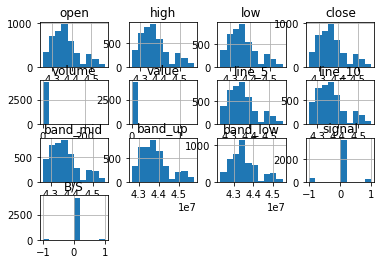

In [9]:
bs_df.hist()

In [10]:
bs_df

,open,high,low,close,volume,value,line_5,line_10,band_mid,band_up,band_low,signal,B/S
2021-05-31 21:30:00,43505000.0,43540000.0,43410000.0,43427000.0,13.250143,5.763957e+08,NaN,NaN,NaN,NaN,NaN,0,0
2021-05-31 21:31:00,43410000.0,43427000.0,43333000.0,43360000.0,9.086987,3.941091e+08,NaN,NaN,NaN,NaN,NaN,0,0
2021-05-31 21:32:00,43362000.0,43423000.0,43300000.0,43300000.0,11.789600,5.109254e+08,NaN,NaN,NaN,NaN,NaN,0,0
2021-05-31 21:33:00,43300000.0,43301000.0,43250000.0,43250000.0,11.726586,5.075380e+08,NaN,NaN,NaN,NaN,NaN,0,0
2021-05-31 21:34:00,43250000.0,43331000.0,43200000.0,43301000.0,26.842492,1.161370e+09,43327600.0,NaN,NaN,NaN,NaN,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-06-03 23:39:00,44767000.0,44769000.0,44747000.0,44769000.0,3.993012,1.787375e+08,44766000.0,44765600.0,44741750.0,4.481921e+07,4.466429e+07,0,0
2021-06-03 23:40:00,44769000.0,44783000.0,44756000.0,44780000.0,3.388031,1.516837e+08,44765400.0,44771500.0,44745750.0,4.482240e+07,4.466910e+07,0,0
2021-06-03 23:41:00,44778000.0,44799000.0,44749000.0,44758000.0,2.931807,1.312514e+08,44766200.0,44770200.0,44750000.0,4.481867e+07,4.468133e+07,0,0
2021-06-03 23:42:00,44758000.0,44771000.0,44732000.0,44742000.0,2.640231,1.181501e+08,44760400.0,44767600.0,44751550.0,4.481787e+07,4.468523e+07,0,0


In [11]:
bs_df=bs_df.dropna(axis=0)

In [24]:
bs_df.reset_index(inplace=True)

In [129]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.preprocessing import LabelEncoder   
from sklearn.model_selection import StratifiedKFold
import numpy as np

In [203]:
x_data=bs_df.iloc[:,[0]]
y_data=bs_df.iloc[:,[4]]

In [204]:
(x_data['index']-x_data['index'].min()) /np.timedelta64(1,'M')

0       0.000000
1       0.000023
2       0.000046
3       0.000068
4       0.000091
          ...   
4296    0.101074
4297    0.101097
4298    0.101120
4299    0.101143
4300    0.101166
Name: index, Length: 4301, dtype: float64

In [205]:
x_data=(x_data['index'] - x_data['index'].min())  / np.timedelta64(1,'M')

In [206]:
x_data

0       0.000000
1       0.000023
2       0.000046
3       0.000068
4       0.000091
          ...   
4296    0.101074
4297    0.101097
4298    0.101120
4299    0.101143
4300    0.101166
Name: index, Length: 4301, dtype: float64

In [207]:
x_data=x_data.values

In [222]:
len(x_data)

4301

In [209]:
y_data

,close
0,43319000.0
1,43361000.0
2,43304000.0
3,43401000.0
4,43329000.0
...,...
4296,44769000.0
4297,44780000.0
4298,44758000.0
4299,44742000.0


In [210]:
y_data= y_data.assign(s1=np.where(y_data['close'] > y_data['close'].quantile(.75),1,0))  # SettingWithCopyWarning 제거
y_data= y_data.assign(s2=np.where((y_data['close']> y_data['close'].quantile(.5)) & (y_data['close']<= y_data['close'].quantile(.75)),1,0))
y_data= y_data.assign(s3=np.where((y_data['close'] > y_data['close'].quantile(.25)) & (y_data['close'] <= y_data['close'].quantile(.5)),1,0))
y_data= y_data.assign(s4=np.where(y_data['close'] <= y_data['close'].quantile(.25),1,0))

In [211]:
y_data=y_data.iloc[:,1:].values

In [224]:
y_data

array([[0, 0, 1, 0],
       [0, 0, 1, 0],
       [0, 0, 1, 0],
       ...,
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0]])

In [225]:
x_train, x_test, y_train, y_test=x_data[:3000], x_data[3000:], y_data[:3000], y_data[3000:]

In [226]:
x_train.shape

(3000,)

In [227]:
y_train.shape

(3000, 4)

In [228]:
model=Sequential()
model.add(Dense(64,input_dim=1, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(4, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(x_train, y_train, epochs=100, batch_size=50)
model.evaluate(x_test, y_test)

Epoch 1/100
60/60 [==============================] - 0s 694us/step - loss: 1.3665 - accuracy: 0.3487
Epoch 2/100
60/60 [==============================] - 0s 627us/step - loss: 1.3064 - accuracy: 0.3600
Epoch 3/100
60/60 [==============================] - 0s 612us/step - loss: 1.2740 - accuracy: 0.3600
Epoch 4/100
60/60 [==============================] - 0s 698us/step - loss: 1.2736 - accuracy: 0.3600
Epoch 5/100
60/60 [==============================] - 0s 676us/step - loss: 1.2716 - accuracy: 0.3600
Epoch 6/100
60/60 [==============================] - 0s 664us/step - loss: 1.2711 - accuracy: 0.3600
Epoch 7/100
60/60 [==============================] - 0s 659us/step - loss: 1.2699 - accuracy: 0.3600
Epoch 8/100
60/60 [==============================] - 0s 620us/step - loss: 1.2693 - accuracy: 0.3600
Epoch 9/100
60/60 [==============================] - 0s 634us/step - loss: 1.2680 - accuracy: 0.3600
Epoch 10/100
60/60 [==============================] - 0s 642us/step - loss: 1.2667 - accura

60/60 [==============================] - 0s 751us/step - loss: 0.8350 - accuracy: 0.6340
Epoch 82/100
60/60 [==============================] - 0s 644us/step - loss: 0.8351 - accuracy: 0.6487
Epoch 83/100
60/60 [==============================] - 0s 709us/step - loss: 0.8344 - accuracy: 0.6307
Epoch 84/100
60/60 [==============================] - 0s 714us/step - loss: 0.8348 - accuracy: 0.6270
Epoch 85/100
60/60 [==============================] - 0s 760us/step - loss: 0.8344 - accuracy: 0.6300
Epoch 86/100
60/60 [==============================] - 0s 711us/step - loss: 0.8321 - accuracy: 0.6383
Epoch 87/100
60/60 [==============================] - 0s 750us/step - loss: 0.8307 - accuracy: 0.6530
Epoch 88/100
60/60 [==============================] - 0s 684us/step - loss: 0.8275 - accuracy: 0.6257
Epoch 89/100
60/60 [==============================] - 0s 617us/step - loss: 0.8311 - accuracy: 0.6337
Epoch 90/100
60/60 [==============================] - 0s 810us/step - loss: 0.8295 - accuracy: 

[2.8893213272094727, 0.641045331954956]

In [230]:
predicted=model.predict(x_data)

In [236]:
test=bs_df.iloc[:,[0]][:3000]

In [243]:
test['ex']=0
for i in range(len(test)):
    test.loc[i,'ex']=predicted[i].argmax()

In [244]:
test

,index,ex
0,2021-05-31 21:49:00,2
1,2021-05-31 21:50:00,2
2,2021-05-31 21:51:00,2
3,2021-05-31 21:52:00,2
4,2021-05-31 21:53:00,2
...,...,...
2995,2021-06-03 01:58:00,0
2996,2021-06-03 01:59:00,0
2997,2021-06-03 02:00:00,0
2998,2021-06-03 02:01:00,0


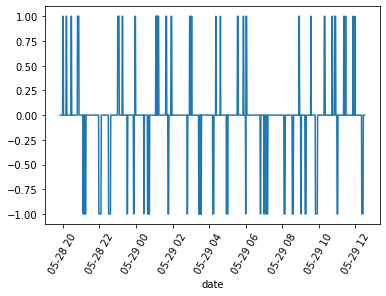

In [199]:
fig2=plt.plot(linear_data_test[['ds']],linear_data_test[['y']]) # 실제데이터
plt.xticks(rotation=60)
plt.xlabel('date')
fig2

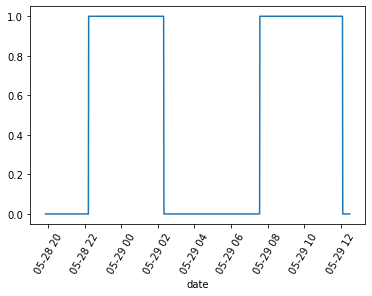

In [200]:
pred['test']=pred['yhat'].map(lambda x: np.round(x*10,0))
fig3=plt.plot(pred[['ds']],pred[['test']])
plt.xticks(rotation=60)
plt.xlabel('date')
fig3

In [198]:
pred.tail(1)

,ds,trend,additive_terms,daily,multiplicative_terms,yhat,test
999,2021-05-29 12:30:00,0.05003,-0.028313,-0.028313,0.0,0.021716,1


In [186]:
test_df=pd.DataFrame(['2021-05-29 12:26:00'], columns=['ds'])
test_df

,ds
0,2021-05-29 12:26:00


In [188]:
pred = ph.predict(test_df)
pred

,ds,trend,additive_terms,daily,multiplicative_terms,yhat
0,2021-05-29 12:26:00,0.049975,-0.023431,-0.023431,0.0,0.026544


In [168]:
knn = KNeighborsClassifier()
param_grid = {
    'n_neighbors':range(1,10),
    'leaf_size':range(1000),
    'n_jobs':range(-1,5)
}
gs_kn = RandomizedSearchCV(knn,                        # 모델 객체
                  param_distributions=param_grid,     # 하이퍼파라미터 목록
                  scoring='accuracy',
                  cv = 5,
                  n_jobs=-1)
gs_kn.fit(X_train, np.ravel(y_train))

RandomizedSearchCV(cv=5, estimator=KNeighborsClassifier(), n_jobs=-1,
                   param_distributions={'leaf_size': range(0, 1000),
                                        'n_jobs': range(-1, 5),
                                        'n_neighbors': range(1, 10)},
                   scoring='accuracy')

In [169]:
pred2 = gs_kn.predict(X_test)
pred_proba2=gs_kn.predict_proba(X_test)
print("최적 모델 사용 시 결과 정확도: ",(pred2==y_test.values).mean())

최적 모델 사용 시 결과 정확도:  0.8339550279867594


In [170]:
print("최적 parameter: ", gs_kn.best_params_)
print("모델 성능: ", gs_kn.best_score_)

최적 parameter:  {'n_neighbors': 7, 'n_jobs': 3, 'leaf_size': 19}
모델 성능:  0.8684385382059802


In [238]:
bs_df_x3

,open,close,volume,line_5,band_up,band_mid,band_low
2021-05-25 18:54:00,46511000.0,46519000.0,6.611729,46491400.0,4.660835e+07,46469950.0,4.633155e+07
2021-05-25 18:55:00,46519000.0,46583000.0,6.514718,46517000.0,4.661088e+07,46483150.0,4.635542e+07
2021-05-25 18:56:00,46586000.0,46516000.0,6.148689,46515200.0,4.661373e+07,46487050.0,4.636037e+07
2021-05-25 18:57:00,46545000.0,46463000.0,10.916125,46518400.0,4.660970e+07,46490650.0,4.637160e+07
2021-05-25 18:58:00,46445000.0,46480000.0,5.476038,46512200.0,4.660876e+07,46493250.0,4.637774e+07
...,...,...,...,...,...,...,...
2021-05-28 18:20:00,43800000.0,43742000.0,24.133896,43851200.0,4.401269e+07,43837500.0,4.366231e+07
2021-05-28 18:21:00,43742000.0,43800000.0,12.339801,43815800.0,4.401266e+07,43838100.0,4.366354e+07
2021-05-28 18:22:00,43865000.0,43814000.0,9.162459,43806200.0,4.400769e+07,43843300.0,4.367891e+07
2021-05-28 18:23:00,43830000.0,43734000.0,18.052190,43778000.0,4.400510e+07,43844500.0,4.368390e+07


In [239]:
bs_df_x2

,open,close,volume,line_5,band_up,band_mid,band_low
2021-05-28 18:25:00,43668000.0,43637000.0,28.087979,43730600.0,4.401492e+07,43821950.0,4.362898e+07
2021-05-28 18:26:00,43637000.0,43581000.0,26.453520,43686800.0,4.401671e+07,43804050.0,4.359139e+07
2021-05-28 18:27:00,43581000.0,43517000.0,25.357263,43627400.0,4.404016e+07,43792400.0,4.354464e+07
2021-05-28 18:28:00,43517000.0,43342000.0,62.276120,43549000.0,4.409021e+07,43770750.0,4.345129e+07
2021-05-28 18:29:00,43343000.0,43398000.0,54.019324,43495000.0,4.411268e+07,43752300.0,4.339192e+07
2021-05-28 18:30:00,43397000.0,43686000.0,33.888161,43504800.0,4.410429e+07,43744900.0,4.338551e+07
2021-05-28 18:31:00,43683000.0,43690000.0,35.579452,43526600.0,4.407446e+07,43730800.0,4.338714e+07
2021-05-28 18:32:00,43692000.0,43690000.0,34.660981,43561200.0,4.406993e+07,43726500.0,4.338307e+07
2021-05-28 18:33:00,43690000.0,43659000.0,26.442107,43624600.0,4.405704e+07,43717150.0,4.337726e+07
2021-05-28 18:34:00,43659000.0,43669000.0,14.139934,43678800.0,4.402970e+07,43704200.0,4.337870e+07


In [236]:
#실제 테스트
real_rf=RandomForestClassifier(n_estimators=gs_rf.best_params_['n_estimators'],
                              max_depth=gs_rf.best_params_['max_depth'],
                              criterion=gs_rf.best_params_['criterion'])
real_rf.fit(X_train, y_train)
pred_y = real_rf.predict(X_test)
bs_df_x2=bs_df_x[-10:]
bs_df_y2=bs_df_y[-10:]
pred = real_rf.predict(bs_df_x2)
print("모델 예측 정확도: ",(pred_y==y_test.values).mean(), "실제 데이터 예측 값: ",pred)

<ipython-input-236-5c4fe9e82827>:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  real_rf.fit(X_train, y_train)


모델 예측 정확도:  0.8291786823425022 실제 데이터 예측 값:  [0 0 0 0 0 0 0 0 0 0]


In [248]:
time2=datetime.datetime.now().strftime('%Y-%m-%d %H:%M:00')
temp = pyupbit.get_ohlcv('KRW-BTC', interval="minute1", count=30, to=time2)
temp=temp[-10:]
temp=BAND_data(temp)
temp
temp2=temp[['open','close','volume','line_5','band_up','band_mid','band_low']]

In [249]:
temp2

,open,close,volume,line_5,band_up,band_mid,band_low
2021-05-28 18:39:00,43748000.0,43898000.0,8.677208,0.0,0.0,0.0,0.0
2021-05-28 18:40:00,43890000.0,43948000.0,27.166781,0.0,0.0,0.0,0.0
2021-05-28 18:41:00,43948000.0,43816000.0,12.356866,0.0,0.0,0.0,0.0
2021-05-28 18:42:00,43839000.0,43883000.0,8.211226,0.0,0.0,0.0,0.0
2021-05-28 18:43:00,43883000.0,43887000.0,6.918352,43886400.0,0.0,0.0,0.0
2021-05-28 18:44:00,43887000.0,43960000.0,7.691097,43898800.0,0.0,0.0,0.0
2021-05-28 18:45:00,43960000.0,43945000.0,8.901094,43898200.0,0.0,0.0,0.0
2021-05-28 18:46:00,43948000.0,44000000.0,18.364306,43935000.0,0.0,0.0,0.0
2021-05-28 18:47:00,44000000.0,43970000.0,9.408846,43952400.0,0.0,0.0,0.0
2021-05-28 18:48:00,43970000.0,43998000.0,16.032234,43974600.0,0.0,0.0,0.0


In [251]:
pred = real_rf.predict(temp2)
print("실제 데이터 예측 값: ",pred)

실제 데이터 예측 값:  [0 0 0 0 0 0 0 0 0 0]


In [207]:
bs_df_x2

,open,close,volume,line_5,band_up,band_mid,band_low
2021-05-28 18:06:00,43936000.0,43939000.0,16.227540,43823000.0,4.493382e+07,44172200.0,4.341058e+07
2021-05-28 18:07:00,43939000.0,43750000.0,24.484346,43831000.0,4.486073e+07,44123500.0,4.338627e+07
2021-05-28 18:08:00,43756000.0,43775000.0,23.298227,43844000.0,4.479026e+07,44080100.0,4.336994e+07
2021-05-28 18:09:00,43775000.0,43767000.0,26.236061,43834000.0,4.470556e+07,44035950.0,4.336634e+07
2021-05-28 18:10:00,43781000.0,43834000.0,29.045745,43813000.0,4.459771e+07,43994050.0,4.339039e+07
2021-05-28 18:11:00,43834000.0,43972000.0,14.684142,43819600.0,4.446802e+07,43958550.0,4.344908e+07
2021-05-28 18:12:00,43983000.0,43776000.0,18.384514,43824800.0,4.435257e+07,43919950.0,4.348733e+07
2021-05-28 18:13:00,43776000.0,43846000.0,18.123153,43839000.0,4.422162e+07,43887050.0,4.355248e+07
2021-05-28 18:14:00,43846000.0,43928000.0,22.730984,43871200.0,4.405821e+07,43860250.0,4.366229e+07
2021-05-28 18:15:00,43928000.0,43943000.0,21.378601,43893000.0,4.404034e+07,43855650.0,4.367096e+07


In [9]:
import prophet
from sklearn.model_selection import train_test_split, RandomizedSearchCV
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score

Importing plotly failed. Interactive plots will not work.


In [36]:
import prophet

In [39]:
m=Prophet()